# Calculate the Balance Index(BI), Highest BI Recipe and Personalized Recipe

In [42]:
import pandas as pd
import numpy as np
import re
import math
import matplotlib.pyplot as plt
import operator

import seaborn as sns

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from sklearn.preprocessing import normalize

In [43]:
db = pd.read_csv('Data/recipe_final.csv', encoding = "ISO-8859-1")
db.head()

,recipename,labels,Total Fat,Saturated Fat,Cholesterol,Sodium,Potassium,Total Carbohydrates,Dietary Fiber,Protein,...,Iron,Thiamin,Niacin,Vitamin B6,Magnesium,Folate,Calories,Health Score,ratings,class_prob
0,1 dish chicken parmesan,4,0.253846,0.25,0.216667,0.309167,0.131714,0.125333,0.124,0.536,...,0.166667,0.0,0.85,0.5,0.1200,0.1775,412,-2.303607,4.093571,0.817866
1,1 dish pepperoni cheese pizza bake,4,0.230769,0.30,0.113333,0.288333,0.027714,0.107333,0.052,0.306,...,0.111111,0.0,0.30,0.0,0.0475,0.1775,329,-3.592734,4.548874,0.811078
2,1 pea salad most requested,3,0.412308,0.15,0.026667,0.117917,0.080000,0.058000,0.240,0.176,...,0.111111,0.0,0.15,0.0,0.1825,0.1400,333,-1.992816,4.149361,0.987261
3,15 minute herbed chicken,6,0.138462,0.10,0.243333,0.237083,0.070857,0.023333,0.048,0.534,...,0.055556,0.0,0.80,0.0,0.0650,0.0125,225,0.738758,4.338405,0.947147
4,2 step creamy chicken and pasta,7,0.178462,0.15,0.266667,0.260000,0.040571,0.101667,0.172,0.578,...,0.055556,0.0,0.55,0.0,0.0475,0.0050,340,-0.303774,4.113393,0.756919


In [44]:
#standard % daily value for normal people with 2000 kcal
dailyvals_2000 = {'Total Fat': 65, 'Saturated Fat': 20, 'Cholesterol': 300, 'Sodium': 2400, 'Potassium': 3500,
             'Total Carbohydrates': 300, 'Dietary Fiber': 25, 'Protein': 50, 'Sugars': 31.5,'Vitamin A': 5000,
             'Vitamin C': 60, 'Calcium': 1000, 'Iron': 18, 'Thiamin': 1.5, 'Niacin': 20, 'Vitamin B6': 2, 'Folate': 400,
            'Magnesium': 400, 'Energy': 2000}



In [45]:
#standard % daily value for each nutrient for pragnant woman with 2300 kcal
#https://www.fda.gov/Food/GuidanceRegulation/GuidanceDocumentsRegulatoryInformation/DietarySupplements/ucm070620.htm

dailyvals = {'Total Fat': 65, 'Saturated Fat': 20, 'Cholesterol': 300, 'Sodium': 2400, 'Potassium': 3500,
             'Total Carbohydrates': 300, 'Dietary Fiber': 25, 'Protein': 100, 'Sugars': 31.5,'Vitamin A': 8000,
             'Vitamin C': 60, 'Calcium': 1300, 'Iron': 27, 'Thiamin': 1.7, 'Niacin': 20, 'Vitamin B6': 2.5, 'Folate': 800,
            'Magnesium': 400, 'Energy': 2300}

# 1. Calculate current BI score for each recipe

In [46]:
# conver the nutrient to per serving
#  Macro Nutrients
db['Total Carbohydrates'] = db['Total Carbohydrates'] * dailyvals_2000['Total Carbohydrates'] 
db['Protein'] = db['Protein'] * dailyvals_2000['Protein'] 
# good nutrient
db['Vitamin A'] = db['Vitamin A'] * dailyvals_2000['Vitamin A'] 
db['Vitamin C'] = db['Vitamin C'] * dailyvals_2000['Vitamin C'] 
db['Calcium'] = db['Calcium'] * dailyvals_2000['Calcium'] 
db['Iron'] = db['Iron'] * dailyvals_2000['Iron'] 
db['Thiamin'] = db['Thiamin'] * dailyvals_2000['Thiamin'] 
db['Niacin'] = db['Niacin'] * dailyvals_2000['Niacin'] 
db['Vitamin B6'] = db['Vitamin B6'] * dailyvals_2000['Vitamin B6'] 
db['Magnesium'] = db['Magnesium'] * dailyvals_2000['Magnesium'] 
db['Folate'] = db['Folate'] * dailyvals_2000['Folate'] 
db['Potassium'] = db['Potassium'] * dailyvals_2000['Potassium'] 
db['Dietary Fiber'] = db['Dietary Fiber'] * dailyvals_2000['Dietary Fiber'] 
# moderate nutrient
db['Total Fat'] = db['Total Fat'] * dailyvals_2000['Total Fat'] 
db['Saturated Fat'] = db['Saturated Fat'] * dailyvals_2000['Saturated Fat'] 
db['Cholesterol'] = db['Cholesterol'] * dailyvals_2000['Cholesterol'] 
db['Sodium'] = db['Sodium'] * dailyvals_2000['Sodium'] 
db['Sugars'] = db['Sugars'] * dailyvals_2000['Sugars'] 


# standardized to 23000 Kcal intake
db['Carb_std'] = db['Total Carbohydrates'] / db['Calories'] * dailyvals['Energy']
db['Protein_std'] = db['Protein'] / db['Calories'] * dailyvals['Energy']
db['VitA_std'] = db['Vitamin A'] / db['Calories'] * dailyvals['Energy']
db['VitC_std'] = db['Vitamin C'] / db['Calories'] * dailyvals['Energy']
db['Calcium_std'] = db['Calcium'] / db['Calories'] * dailyvals['Energy']
db['Iron_std'] = db['Iron'] / db['Calories'] * dailyvals['Energy']
db['Thiamin_std'] = db['Thiamin'] / db['Calories'] * dailyvals['Energy']
db['Niacin_std'] = db['Niacin'] / db['Calories'] * dailyvals['Energy']
db['VitB6_std'] = db['Vitamin B6'] / db['Calories'] * dailyvals['Energy']
db['Magnesium_std'] = db['Magnesium'] / db['Calories'] * dailyvals['Energy']
db['Folate_std'] = db['Folate'] / db['Calories'] * dailyvals['Energy']
db['Potassium_std'] = db['Potassium'] / db['Calories'] * dailyvals['Energy']
db['Dietary Fiber_std'] = db['Dietary Fiber'] / db['Calories'] * dailyvals['Energy']
# moderate nutrient
db['Total Fat_std'] = db['Total Fat'] / db['Calories'] * dailyvals['Energy']
db['Saturated Fat_std'] = db['Saturated Fat'] / db['Calories'] * dailyvals['Energy']
db['Cholesterol_std'] = db['Cholesterol'] / db['Calories'] * dailyvals['Energy']
db['Sodium_std'] = db['Sodium'] / db['Calories'] * dailyvals['Energy']
db['Sugars_std'] = db['Sugars'] / db['Calories'] * dailyvals['Energy']

    

# calculate the BI
db['Carb_BI'] = [x / dailyvals['Total Carbohydrates'] * 5 if x < dailyvals['Total Carbohydrates'] else 10 for x in db['Carb_std']]
db['Protein_BI'] = [x / dailyvals['Protein'] * 15 if x < dailyvals['Protein'] else 10 for x in db['Protein_std']]
db['VitA_BI'] = [x / dailyvals['Vitamin A'] * 5 if x < dailyvals['Vitamin A'] else 5 for x in db['VitA_std']]
db['VitC_BI'] = [x / dailyvals['Vitamin C'] * 5 if x < dailyvals['Vitamin C'] else 5 for x in db['VitC_std']]
db['Calcium_BI'] = [x / dailyvals['Calcium'] * 5 if x < dailyvals['Calcium'] else 5 for x in db['Calcium_std']]
db['Iron_BI'] = [x / dailyvals['Iron'] * 5 if x < dailyvals['Iron'] else 5 for x in db['Iron_std']]
db['Thiamin_BI'] = [x / dailyvals['Thiamin'] * 5 if x < dailyvals['Thiamin'] else 5 for x in db['Thiamin_std']]
db['Niacin_BI'] = [x / dailyvals['Niacin'] * 5 if x < dailyvals['Niacin'] else 5 for x in db['Niacin_std']]
db['VitB6_BI'] = [x / dailyvals['Vitamin B6'] * 5 if x < dailyvals['Vitamin B6'] else 5 for x in db['VitB6_std']]
db['Magnesium_BI'] = [x / dailyvals['Magnesium'] * 5 if x < dailyvals['Magnesium'] else 5 for x in db['Magnesium_std']]
db['Folate_BI'] = [x / dailyvals['Folate'] * 5 if x < dailyvals['Folate'] else 5 for x in db['Folate_std']]
db['Potassium_BI'] = [x / dailyvals['Potassium'] * 5 if x < dailyvals['Potassium'] else 5 for x in db['Potassium_std']]
db['Dietary Fiber_BI'] = [x / dailyvals['Dietary Fiber'] * 5 if x < dailyvals['Dietary Fiber'] else 5 for x in db['Dietary Fiber_std']]
# nutrient of moderate intake
db['Total Fat_BI'] = [(dailyvals['Total Fat'] - x) / dailyvals['Total Fat'] * 5 if x < dailyvals['Total Fat'] else 0 for x in db['Total Fat_std'] ]
db['Saturated Fat_BI'] = [(dailyvals['Saturated Fat'] - x) / dailyvals['Saturated Fat'] * 5 if x < dailyvals['Saturated Fat'] else 0 for x in db['Saturated Fat_std'] ]
db['Cholesterol_BI'] = [(dailyvals['Cholesterol'] - x) / dailyvals['Cholesterol'] * 5 if x < dailyvals['Cholesterol'] else 0 for x in db['Cholesterol_std'] ]
db['Sodium_BI'] = [(dailyvals['Sodium'] - x) / dailyvals['Sodium'] * 5 if x < dailyvals['Sodium'] else 0 for x in db['Sodium_std'] ]
db['Sugars_BI'] = [(dailyvals['Sugars'] - x) / dailyvals['Sugars'] * 5 if x < dailyvals['Sugars'] else 0 for x in db['Sugars_std'] ]


# total BI
db['BI'] = db['Carb_BI'] + db['Protein_BI'] + db['VitA_BI'] + db['VitC_BI'] + db['Calcium_BI'] + db['Iron_BI'] + \
            db['Thiamin_BI'] + db['Niacin_BI'] + db['VitB6_BI'] + db['Magnesium_BI'] + db['Folate_BI'] + db['Potassium_BI'] + \
            db['Dietary Fiber_BI'] + db['Total Fat_BI'] + db['Saturated Fat_BI'] + db['Sodium_BI'] + db['Sugars_BI']





In [47]:

db.head()

,recipename,labels,Total Fat,Saturated Fat,Cholesterol,Sodium,Potassium,Total Carbohydrates,Dietary Fiber,Protein,...,Magnesium_BI,Folate_BI,Potassium_BI,Dietary Fiber_BI,Total Fat_BI,Saturated Fat_BI,Cholesterol_BI,Sodium_BI,Sugars_BI,BI
0,1 dish chicken parmesan,4,16.5,5.0,65.0,742.000001,461.000001,37.6,3.1,26.8,...,3.349515,2.477245,3.676491,3.461165,0.0,0.0,0.000000,0.000000,0.000000,46.434641
1,1 dish pepperoni cheese pizza bake,4,15.0,6.0,34.0,691.999999,97.000001,32.2,1.3,15.3,...,1.660334,3.102204,0.968736,1.817629,0.0,0.0,1.038501,0.000000,1.671009,37.936344
2,1 pea salad most requested,3,26.8,3.0,8.0,283.000001,280.000000,17.4,6.0,8.8,...,5.000000,2.417417,2.762763,5.000000,0.0,0.0,4.079079,0.927803,0.000000,46.619204
3,15 minute herbed chicken,6,9.0,2.0,73.0,568.999999,248.000000,7.0,1.2,26.7,...,3.322222,0.319444,3.621587,2.453333,0.0,0.0,0.000000,0.000000,1.754850,31.916991
4,2 step creamy chicken and pasta,7,11.6,3.0,80.0,624.000000,142.000001,30.5,4.3,28.9,...,1.606618,0.084559,1.372269,5.000000,0.0,0.0,0.000000,0.000000,0.704949,28.805233


In [48]:
# save for the recommendation on the higest BI and Highest BI within the cluster

db.to_csv('Data/BI_onerecipe_v4.csv', index=False)


# 2.  BI of Combined Recipe

In [49]:
db = pd.read_csv('Data/BI_onerecipe_v4.csv')
db

,recipename,labels,Total Fat,Saturated Fat,Cholesterol,Sodium,Potassium,Total Carbohydrates,Dietary Fiber,Protein,...,Magnesium_BI,Folate_BI,Potassium_BI,Dietary Fiber_BI,Total Fat_BI,Saturated Fat_BI,Cholesterol_BI,Sodium_BI,Sugars_BI,BI
0,1 dish chicken parmesan,4,16.5,5.0,65.0,742.000001,461.000001,37.6,3.1,26.8,...,3.349515,2.477245,3.676491,3.461165,0.000000,0.000000,0.000000,0.000000,0.000000,46.434641
1,1 dish pepperoni cheese pizza bake,4,15.0,6.0,34.0,691.999999,97.000001,32.2,1.3,15.3,...,1.660334,3.102204,0.968736,1.817629,0.000000,0.000000,1.038501,0.000000,1.671009,37.936344
2,1 pea salad most requested,3,26.8,3.0,8.0,283.000001,280.000000,17.4,6.0,8.8,...,5.000000,2.417417,2.762763,5.000000,0.000000,0.000000,4.079079,0.927803,0.000000,46.619204
3,15 minute herbed chicken,6,9.0,2.0,73.0,568.999999,248.000000,7.0,1.2,26.7,...,3.322222,0.319444,3.621587,2.453333,0.000000,0.000000,0.000000,0.000000,1.754850,31.916991
4,2 step creamy chicken and pasta,7,11.6,3.0,80.0,624.000000,142.000001,30.5,4.3,28.9,...,1.606618,0.084559,1.372269,5.000000,0.000000,0.000000,0.000000,0.000000,0.704949,28.805233
5,2 step skillet chicken broccoli divan,2,15.6,7.0,90.0,726.000000,420.999999,12.3,3.0,30.4,...,3.709677,2.318548,4.462212,4.451613,0.000000,0.000000,0.000000,0.000000,1.466974,47.698302
6,25 minute tunisian vegetable couscous,4,4.9,1.0,0.0,699.000000,487.000000,72.1,8.8,13.6,...,5.000000,3.194444,4.134736,5.000000,2.759889,3.514212,5.000000,0.000000,0.283212,71.232371
7,3 cheese eggplant lasagna,4,16.0,6.0,80.0,2475.000000,787.000000,20.8,4.5,17.3,...,5.000000,3.429825,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.710916
8,3 ingredient pulled pork barbeque,9,16.4,6.0,106.0,922.000001,529.999999,23.9,0.5,32.2,...,2.408377,0.112893,4.558714,0.602094,0.000000,0.000000,0.000000,0.000000,0.000000,39.360510
9,30 minute irish skillet,4,19.3,6.0,52.0,714.000000,336.000000,24.6,4.1,16.8,...,1.849415,1.429094,3.228070,5.000000,0.000000,0.000000,0.000000,0.000000,0.730066,38.676523


recipe_option

In [50]:
# Method 2: to increase the speed 

def BI_combine(recipename):   # for 1 input
    db = pd.read_csv('Data/BI_onerecipe_v4.csv')
    dailyvals = {'Total Fat': 65, 'Saturated Fat': 20, 'Cholesterol': 300, 'Sodium': 2400, 'Potassium': 3500,
             'Total Carbohydrates': 300, 'Dietary Fiber': 25, 'Protein': 100, 'Sugars': 31.5,'Vitamin A': 8000,
             'Vitamin C': 60, 'Calcium': 1300, 'Iron': 27, 'Thiamin': 1.7, 'Niacin': 20, 'Vitamin B6': 2.5, 'Folate': 800,
            'Magnesium': 400, 'Energy': 2300}
    recipe_input = db[db['recipename']==recipename]

    # construct a set of combined recipes
    db.iloc[:,3:] += recipe_input.iloc[0,3:]
    
#     db.set_index(['recipename','labels'], inplace=True)
    db_combine = db[['recipename','labels','Total Fat','Saturated Fat','Cholesterol','Sodium', 'Total Carbohydrates','Sugars', \
                                   'Protein','Dietary Fiber','Vitamin A','Vitamin C','Calcium','Potassium','Iron',\
                                   'Thiamin','Niacin','Vitamin B6','Magnesium','Folate', 'Calories']]

   
    db_combine['Carb_std'] = db_combine['Total Carbohydrates'] / db_combine['Calories'] * dailyvals['Energy']
    db_combine['Protein_std'] = db_combine['Protein'] / db_combine['Calories'] * dailyvals['Energy']
    db_combine['VitA_std'] = db_combine['Vitamin A'] / db_combine['Calories'] * dailyvals['Energy']
    db_combine['VitC_std'] = db_combine['Vitamin C'] / db_combine['Calories'] * dailyvals['Energy']
    db_combine['Calcium_std'] = db_combine['Calcium'] / db_combine['Calories'] * dailyvals['Energy']
    db_combine['Iron_std'] = db_combine['Iron'] / db_combine['Calories'] * dailyvals['Energy']
    db_combine['Thiamin_std'] = db_combine['Thiamin'] / db_combine['Calories'] * dailyvals['Energy']
    db_combine['Niacin_std'] = db_combine['Niacin'] / db_combine['Calories'] * dailyvals['Energy']
    db_combine['VitB6_std'] = db_combine['Vitamin B6'] / db_combine['Calories'] * dailyvals['Energy']
    db_combine['Magnesium_std'] = db_combine['Magnesium'] / db_combine['Calories'] * dailyvals['Energy']
    db_combine['Folate_std'] = db_combine['Folate'] / db_combine['Calories'] * dailyvals['Energy']
    db_combine['Potassium_std'] = db_combine['Potassium'] / db_combine['Calories'] * dailyvals['Energy']
    db_combine['Dietary Fiber_std'] = db_combine['Dietary Fiber'] / db_combine['Calories'] * dailyvals['Energy']
    # moderate nutrient
    db_combine['Total Fat_std'] = db_combine['Total Fat'] / db_combine['Calories'] * dailyvals['Energy']
    db_combine['Saturated Fat_std'] = db_combine['Saturated Fat'] / db_combine['Calories'] * dailyvals['Energy']
    db_combine['Cholesterol_std'] = db_combine['Cholesterol'] / db_combine['Calories'] * dailyvals['Energy']
    db_combine['Sodium_std'] = db_combine['Sodium'] / db_combine['Calories'] * dailyvals['Energy']
    db_combine['Sugars_std'] = db_combine['Sugars'] / db_combine['Calories'] * dailyvals['Energy']

    # calculate the BI
    db_combine['Carb_BI'] = [x / dailyvals['Total Carbohydrates'] * 5 if x < dailyvals['Total Carbohydrates'] else 5 for x in db_combine['Carb_std']]
    db_combine['Protein_BI'] = [x / dailyvals['Protein'] * 15 if x < dailyvals['Protein'] else 15 for x in db_combine['Protein_std']]
    db_combine['VitA_BI'] = [x / dailyvals['Vitamin A'] * 5 if x < dailyvals['Vitamin A'] else 5 for x in db_combine['VitA_std']]
    db_combine['VitC_BI'] = [x / dailyvals['Vitamin C'] * 5 if x < dailyvals['Vitamin C'] else 5 for x in db_combine['VitC_std']]
    db_combine['Calcium_BI'] = [x / dailyvals['Calcium'] * 5 if x < dailyvals['Calcium'] else 5 for x in db_combine['Calcium_std']]
    db_combine['Iron_BI'] = [x / dailyvals['Iron'] * 5 if x < dailyvals['Iron'] else 5 for x in db_combine['Iron_std']]
    db_combine['Thiamin_BI'] = [x / dailyvals['Thiamin'] * 5 if x < dailyvals['Thiamin'] else 5 for x in db_combine['Thiamin_std']]
    db_combine['Niacin_BI'] = [x / dailyvals['Niacin'] * 5 if x < dailyvals['Niacin'] else 5 for x in db_combine['Niacin_std']]
    db_combine['VitB6_BI'] = [x / dailyvals['Vitamin B6'] * 5 if x < dailyvals['Vitamin B6'] else 5 for x in db_combine['VitB6_std']]
    db_combine['Magnesium_BI'] = [x / dailyvals['Magnesium'] * 5 if x < dailyvals['Magnesium'] else 5 for x in db_combine['Magnesium_std']]
    db_combine['Folate_BI'] = [x / dailyvals['Folate'] * 5 if x < dailyvals['Folate'] else 5 for x in db_combine['Folate_std']]
    db_combine['Potassium_BI'] = [x / dailyvals['Potassium'] * 5 if x < dailyvals['Potassium'] else 5 for x in db_combine['Potassium_std']]
    db_combine['Dietary Fiber_BI'] = [x / dailyvals['Dietary Fiber'] * 5 if x < dailyvals['Dietary Fiber'] else 5 for x in db_combine['Dietary Fiber_std']]

    # nutrient of moderate intake
    db_combine['Total Fat_BI'] = [(dailyvals['Total Fat'] - x) / dailyvals['Total Fat'] * 5 if x < dailyvals['Total Fat'] else 0 for x in db_combine['Total Fat_std'] ]
    db_combine['Saturated Fat_BI'] = [(dailyvals['Saturated Fat'] - x) / dailyvals['Saturated Fat'] * 5 if x < dailyvals['Saturated Fat'] else 0 for x in db_combine['Saturated Fat_std'] ]
    db_combine['Cholesterol_BI'] = [(dailyvals['Cholesterol'] - x) / dailyvals['Cholesterol'] * 5 if x < dailyvals['Cholesterol'] else 0 for x in db_combine['Cholesterol_std'] ]
    db_combine['Sodium_BI'] = [(dailyvals['Sodium'] - x) / dailyvals['Sodium'] * 5 if x < dailyvals['Sodium'] else 0 for x in db_combine['Sodium_std'] ]
    db_combine['Sugars_BI'] = [(dailyvals['Sugars'] - x) / dailyvals['Sugars'] * 5 if x < dailyvals['Sugars'] else 0 for x in db_combine['Sugars_std'] ]


    # total BI
    db_combine['BI_combine'] = db_combine['Carb_BI'] + db_combine['Protein_BI'] + db_combine['VitA_BI'] + db_combine['VitC_BI'] + db_combine['Calcium_BI'] + db_combine['Iron_BI'] + \
                db_combine['Thiamin_BI'] + db_combine['Niacin_BI'] + db_combine['VitB6_BI'] + db_combine['Magnesium_BI'] + db_combine['Folate_BI'] + db_combine['Potassium_BI'] + \
                db_combine['Dietary Fiber_BI'] + db_combine['Total Fat_BI'] + db_combine['Saturated Fat_BI'] + db_combine['Sodium_BI'] + db_combine['Sugars_BI']


    db_recommend_recipe = db_combine['recipename'][db_combine['BI_combine'].idxmax()]
    db_recommend_BI_score = db_combine['BI_combine'][db_combine['BI_combine'].idxmax()]
                                     
    return db_recommend_recipe, db_recommend_BI_score, db_combine

# db_recommend_recipe: is the name of the recipe with the highest BI Score
# db_recommend_BI_score: the highest BI score
# db_combine: a new dataframe with all BI score for combined recipes


# test on the Global recommendation
import time
start = time.time()

db_recommend_recipe, BI_score, BI_combined = BI_combine('1 dish chicken parmesan')

BI_combined.to_csv('Data/BI_combined_v4.csv', index=False)
end = time.time()
print(end - start)   
 


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

2.1781821250915527


In [61]:

db_recommend_recipe

'spaghetti with marinara sauce'

In [31]:
BI_combined

,recipename,labels,Total Fat,Saturated Fat,Cholesterol,Sodium,Total Carbohydrates,Sugars,Protein,Dietary Fiber,...,Magnesium_BI,Folate_BI,Potassium_BI,Dietary Fiber_BI,Total Fat_BI,Saturated Fat_BI,Cholesterol_BI,Sodium_BI,Sugars_BI,BI_combine
0,1 dish chicken parmesan,4,33,10,130,1484,75.2,18,53.6,6.2,...,3.349515,2.477245,3.676491,3.461165,0.000000,0.000000,0.000000,0.0,0.000000,51.434641
1,1 dish pepperoni cheese pizza bake,4,31.5,11,99,1434,69.8,12,42.1,4.4,...,2.599528,2.754723,2.474263,2.731444,0.000000,0.000000,0.000000,0.0,0.000000,49.710970
2,1 pea salad most requested,3,43.3,8,73,1025,55,15,35.6,9.1,...,4.669463,2.450503,3.268073,5.000000,0.000000,0.000000,1.243848,0.0,0.000000,58.746667
3,15 minute herbed chicken,6,25.5,7,138,1311,44.6,11,53.5,4.3,...,3.339874,1.715071,3.657098,3.105181,0.000000,0.000000,0.000000,0.0,0.000000,47.452989
4,2 step creamy chicken and pasta,7,28.1,8,145,1366,68.1,13,55.7,7.4,...,2.561503,1.395445,2.634688,4.526596,0.000000,0.000000,0.000000,0.0,0.000000,45.775491
5,2 step skillet chicken broccoli divan,2,32.1,12,155,1468,49.9,12,57.2,6.1,...,3.504155,2.409107,4.013850,3.886427,0.000000,0.000000,0.000000,0.0,0.000000,55.887264
6,25 minute tunisian vegetable couscous,4,21.4,6,65,1441,109.7,14,40.4,11.9,...,4.173967,2.824625,3.898444,5.000000,0.261384,0.682103,1.881519,0.0,0.000000,62.711122
7,3 cheese eggplant lasagna,4,32.5,11,145,3217,58.4,15,44.1,7.6,...,4.661047,2.866750,5.000000,5.000000,0.000000,0.000000,0.000000,0.0,0.000000,64.406165
8,3 ingredient pulled pork barbeque,9,32.9,11,171,1664,61.5,25,59,3.6,...,2.896725,1.339736,4.100936,2.085642,0.000000,0.000000,0.000000,0.0,0.000000,50.625676
9,30 minute irish skillet,4,35.8,11,117,1456,62.2,13,43.6,7.2,...,2.669098,2.001824,3.473096,4.392573,0.000000,0.000000,0.000000,0.0,0.000000,52.309585


# 3. BI Local Recommendation

In [60]:

def BI_combine_cluster(recipename, similarity):   # for 1 input
    db = pd.read_csv('Data/BI_combined_v4.csv')
    dist_matrix_transpose = np.loadtxt('Data/dist_matrix_transpose.csv', delimiter=",")

    recipe_input = db[db['recipename']==recipename]

    
    cluster_index = recipe_input['labels']
    similarity = np.max(dist_matrix_transpose, axis=0)[cluster_index] * similarity  # similarity is scaled by the distance matrix
    a = [row[cluster_index] for row in dist_matrix_transpose]
    cluster_option = min(enumerate(a), key=lambda x: abs(x[1]-similarity))  # get the cluster that is most close to the chosen similarity
    db_sub = db[db['labels']==cluster_option[0]]
    db_sub_sorted = db_sub.sort_values(['BI_combine'], ascending = False)
    
    return db_sub_sorted.head(5)     # return the 5 recipe with the top BI score within the selected cluster



# test on the Global recommendation
import time
start = time.time()

BI_combined_5 = BI_combine_cluster('1 dish chicken parmesan', 0.5)
BI_combined_5.to_csv('Data/BI_combined_5_v4.csv', index=False)
end = time.time()
print(end - start)   
 


0.09110713005065918


In [59]:
BI_combined_5

,recipename,labels,Total Fat,Saturated Fat,Cholesterol,Sodium,Total Carbohydrates,Sugars,Protein,Dietary Fiber,...,Magnesium_BI,Folate_BI,Potassium_BI,Dietary Fiber_BI,Total Fat_BI,Saturated Fat_BI,Cholesterol_BI,Sodium_BI,Sugars_BI,BI_combine
3533,roasted carrot and fennel pork,9,7.8,8.0,102.0,2146.000001,63.6,14.0,42.7,12.3,...,4.889764,3.373031,5.000000,5.000000,2.826772,0.000000,0.000000,0.0,0.0,74.555740
3003,one skillet pork supper,9,5.2,6.0,130.0,1569.000000,80.7,18.0,52.1,8.3,...,4.686644,2.264555,5.000000,5.000000,3.739726,0.273973,0.000000,0.0,0.0,71.635890
1432,curried pork chops and cauliflower with basmat...,9,6.8,7.0,102.0,840.000000,113.5,19.0,50.8,8.1,...,3.877143,4.517857,4.720163,4.258286,3.625055,0.400000,0.531429,0.4,0.0,70.353526
3296,pork chop and cabbage casserole,9,8.3,8.0,107.0,1367.000002,91.8,17.0,48.3,10.4,...,4.632353,2.647059,5.000000,5.000000,3.122172,0.000000,0.000000,0.0,0.0,70.341100
3548,roasted pork tenderloin,9,3.8,6.0,130.0,1805.000002,54.1,21.0,51.6,7.5,...,4.470131,2.564444,5.000000,5.000000,3.899660,0.000000,0.000000,0.0,0.0,68.474450


In [33]:
# check BI by Labels

grouped = db['BI'].groupby(db['labels']) #groupby cluster for aggregation purposes
grouped.mean() #average rank (1 to 100) per cluster

labels
0    43.084247
1    52.869860
2    45.878355
3    47.161972
4    44.939481
5    49.176890
6    43.676105
7    52.405669
8    42.029190
9    43.835825
Name: BI, dtype: float64

# 4. Plot the BI Score by nutrients

In [98]:
import io
import base64
import seaborn
import urllib.parse
import pandas as pd

def plot_BI_comparison(recipename):
    # get the BI score for the input recipe

    db = pd.read_csv('Data/BI_onerecipe_v4.csv')
    recipe_input = db[db['recipename']==recipename]
    recipe_input = recipe_input[['recipename', 'Total Fat_BI','Saturated Fat_BI','Cholesterol_BI','Sodium_BI', 'Carb_BI','Sugars_BI',\
                                      'Protein_BI','Dietary Fiber_BI','VitA_BI','VitC_BI','Calcium_BI','Iron_BI','Potassium_BI','Thiamin_BI', \
                                       'Niacin_BI','VitB6_BI', 'Magnesium_BI','Folate_BI','BI']]

    # get the BI score for the best combined recipes (recommended in part 2)
    db_combine = pd.read_csv('Data/BI_combined_v4.csv')
    recipe_recomend = db_combine[db_combine['recipename']==db_recommend_recipe]
    recipe_recomend = recipe_recomend.rename(columns = {'BI_combine':'BI'})
    recipe_recomend = recipe_recomend[['recipename', 'Total Fat_BI','Saturated Fat_BI','Cholesterol_BI','Sodium_BI', 'Carb_BI','Sugars_BI',\
                                      'Protein_BI','Dietary Fiber_BI','VitA_BI','VitC_BI','Calcium_BI','Iron_BI','Potassium_BI','Thiamin_BI',\
                                       'Niacin_BI','VitB6_BI', 'Magnesium_BI','Folate_BI','BI']]

    # get a new dataframe of 2 recipes for plot
    recipe_two = recipe_input.append(recipe_recomend, ignore_index=True)

    recipe_two.to_csv('Data/recipe_two.csv', index = False)

    recipe_two = pd.read_csv('Data/recipe_two.csv').set_index('recipename')

    #combine nutr info and change df to long form 	
    combined_nutrfacts = recipe_two.T.reindex(index=['Total Fat_BI','Saturated Fat_BI','Cholesterol_BI','Sodium_BI', 'Carb_BI','Sugars_BI',\
                                  'Protein_BI','Dietary Fiber_BI','VitA_BI','VitC_BI','Calcium_BI','Iron_BI','Potassium_BI','Thiamin_BI',\
                                   'Niacin_BI','VitB6_BI', 'Magnesium_BI','Folate_BI'])
    combined_nutrfacts = combined_nutrfacts.reset_index().melt(id_vars=['index'])
    combined_nutrfacts = combined_nutrfacts.rename(columns={'index':'nutrients'})


    img = io.BytesIO()
    plt.figure(figsize=(10,15))
    g = seaborn.barplot(y="nutrients",x="value",hue="recipename",data=combined_nutrfacts,
        palette=['k','r'],alpha=0.3)
    ax=plt.gca()
    plt.xlabel('BI score',fontsize=20)
    plt.ylabel('')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
    ax.axvline(15,lw=4,ls=':')
    ax.axvline(5,lw=4,ls=':')
    ax.tick_params(labelsize=20)
    ax.set_yticklabels(labels=combined_nutrfacts['nutrients'])
    ax.legend(loc=1,frameon=False,fontsize=15)

    [i.set_color('r') for i in ax.get_yticklabels() if i.get_text() in ['Total Fat_BI','Saturated Fat_BI',
        'Cholesterol_BI','Sodium_BI','Carb_BI','Sugars_BI']]
    [i.set_color('g') for i in ax.get_yticklabels() if i.get_text() in ['Potassium_BI','Dietary Fiber_BI',
        'Protein_BI','VitA_BI','VitC_BI','Calcium_BI','Iron_BI']]

    plt.tight_layout()
    plt.savefig(img,format='png')
    img.seek(0)
    plot_url = urllib.parse.quote(base64.b64encode(img.read()).decode())
    
    return plot_url

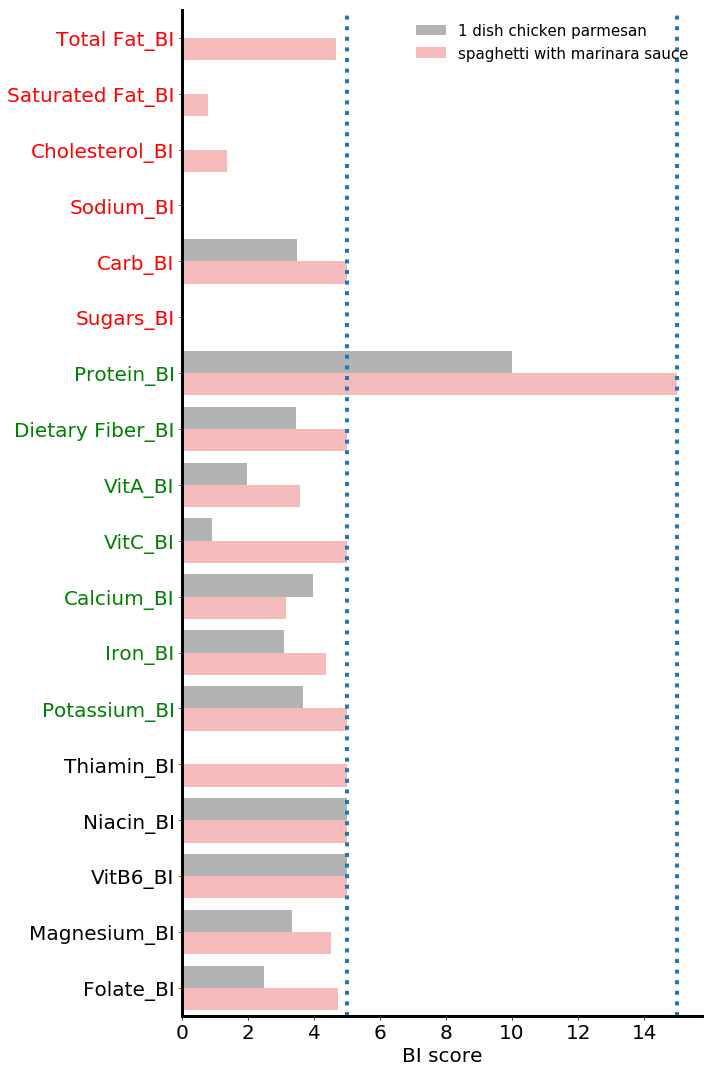

In [99]:
plot_BI_comparison = plot_BI_comparison('1 dish chicken parmesan')